# **Stock Market Analysis**

This notebook explores and analyzes data from the technology stock market, focusing on companies such as Apple, Amazon, Google, and Microsoft. The analysis includes stock risk assessment and utilizes the Long Short-Term Memory (LSTM) method for predicting future stock prices.

Key questions:
- What was the change in price of the stock over time?
- What was the daily return of the stock on average?
- What was the moving average of the various stocks?
- How much value do we put at risk by investing in a particular stock?
- How can we attempt to predict future stock behavior?

**Import Library**

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from adjustText import adjust_text
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from keras.layers import Dense, LSTM, Conv1D, Conv2D, Dropout, MaxPooling3D
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

**Dataset**

In [2]:
# the tech stocks we'll use for the analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
company_name = ['APPLE', 'GOOGLE', 'MICROSOFT', 'AMAZON']

# set up start & end time for data grab
end = datetime(2023, 1, 31)
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

company_list = [AAPL, GOOG, MSFT, AMZN]
for company, name in zip(company_list, company_name):
    company['company_name'] = name
    
df = pd.concat(company_list, axis=0)
df.info()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1004 entries, 2022-01-31 to 2023-01-30
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1004 non-null   float64
 1   High          1004 non-null   float64
 2   Low           1004 non-null   float64
 3   Close         1004 non-null   float64
 4   Adj Close     1004 non-null   float64
 5   Volume        1004 non-null   int64  
 6   company_name  1004 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 62.8+ KB


In [3]:
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2023-01-17,98.680000,98.889999,95.730003,96.050003,96.050003,72755000,AMAZON
2023-01-18,97.250000,99.320000,95.379997,95.459999,95.459999,79570400,AMAZON
2023-01-19,94.739998,95.440002,92.860001,93.680000,93.680000,69002700,AMAZON
2023-01-20,93.860001,97.349998,93.199997,97.250000,97.250000,67481500,AMAZON
2023-01-23,97.559998,97.779999,95.860001,97.519997,97.519997,76501100,AMAZON
2023-01-24,96.930000,98.089996,96.000000,96.320000,96.320000,66929500,AMAZON
2023-01-25,92.559998,97.239998,91.519997,97.180000,97.180000,94261600,AMAZON
2023-01-26,98.239998,99.489998,96.919998,99.220001,99.220001,68523600,AMAZON
2023-01-27,99.529999,103.489998,99.529999,102.239998,102.239998,87775600,AMAZON


In [4]:
round(df.describe(), 2)

,Open,High,Low,Close,Adj Close,Volume
count,1004.00,1004.00,1004.00,1004.00,1004.00,1.004000e+03
mean,162.27,164.56,159.93,162.28,161.10,5.501892e+07
std,63.46,64.07,62.75,63.48,62.05,3.354892e+07
min,82.80,83.48,81.43,81.82,81.82,8.567800e+06
25%,114.08,116.36,112.61,114.56,114.56,2.726908e+07
50%,142.61,144.25,140.33,142.57,141.87,4.771220e+07
75%,188.30,189.81,185.88,187.78,185.82,7.552370e+07
max,313.91,315.95,311.58,315.41,310.38,2.726620e+08


In [5]:
df['company_name'].value_counts()

APPLE        251
GOOGLE       251
MICROSOFT    251
AMAZON       251
Name: company_name, dtype: int64

## **EDA**

### **What was the change in price of the stock over time?**

**Close Price**

The closing price is the last price at which the stock is traded during the regular trading day. A stock's closing price is the standard benchmark used by investors to track its performance over time.

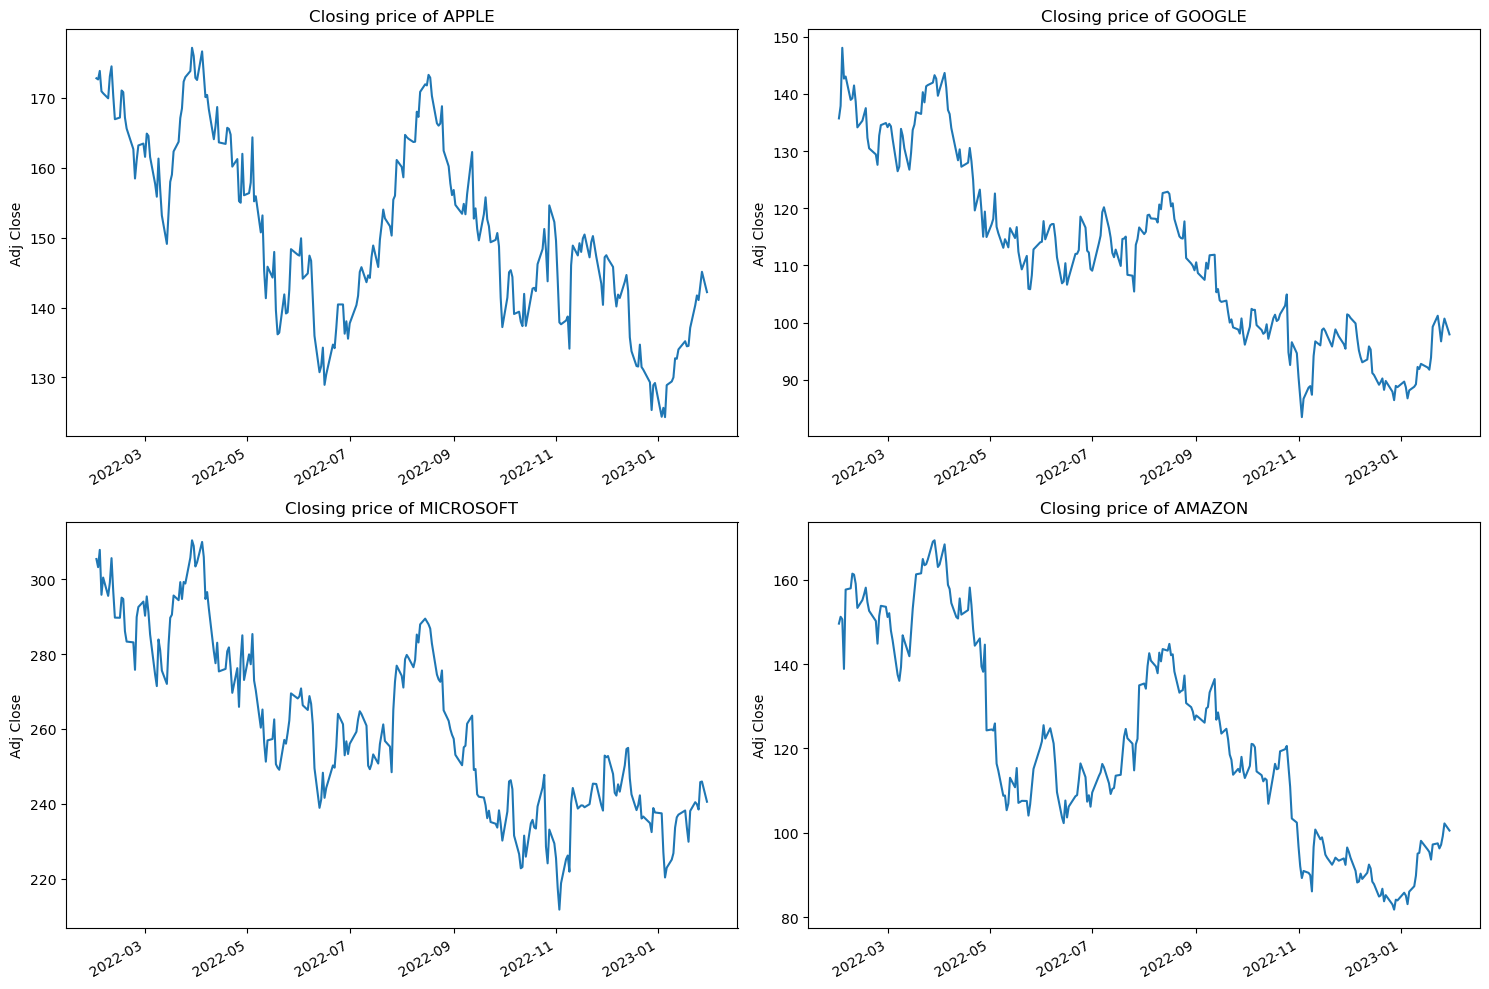

In [10]:
plt.figure(figsize = (15, 10))
plt.subplots_adjust(top = 1.25, bottom = 1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f'Closing price of {company_name[i - 1]}')
    
plt.tight_layout()
plt.show()

**Volume of Sales**

Volume is the amount of an asset or security that changes hands over some period of time, often over the course of a day. For instance, the stock trading volume would refer to the number of shares of security traded between its daily open and close. Trading volume, and changes to volume over the course of time, are important inputs for technical traders.

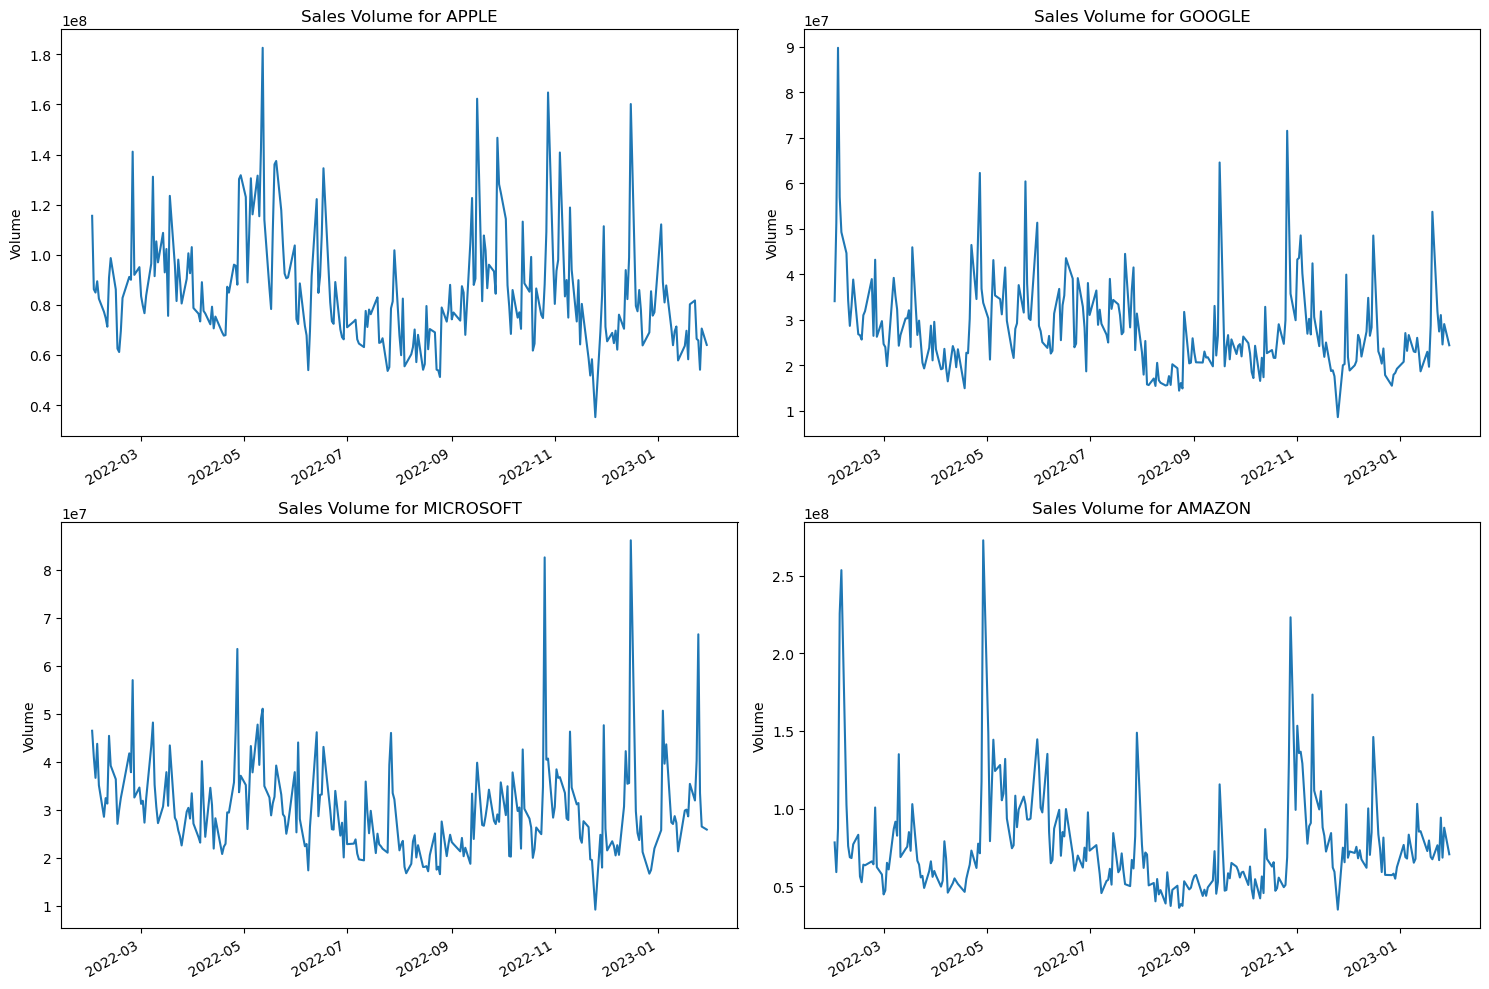

In [11]:
plt.figure(figsize = (15, 10))
plt.subplots_adjust(top = 1.25, bottom = 1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f'Sales Volume for {company_name[i - 1]}')
    
plt.tight_layout()
plt.show()

### **What was the moving average of the various stocks?**

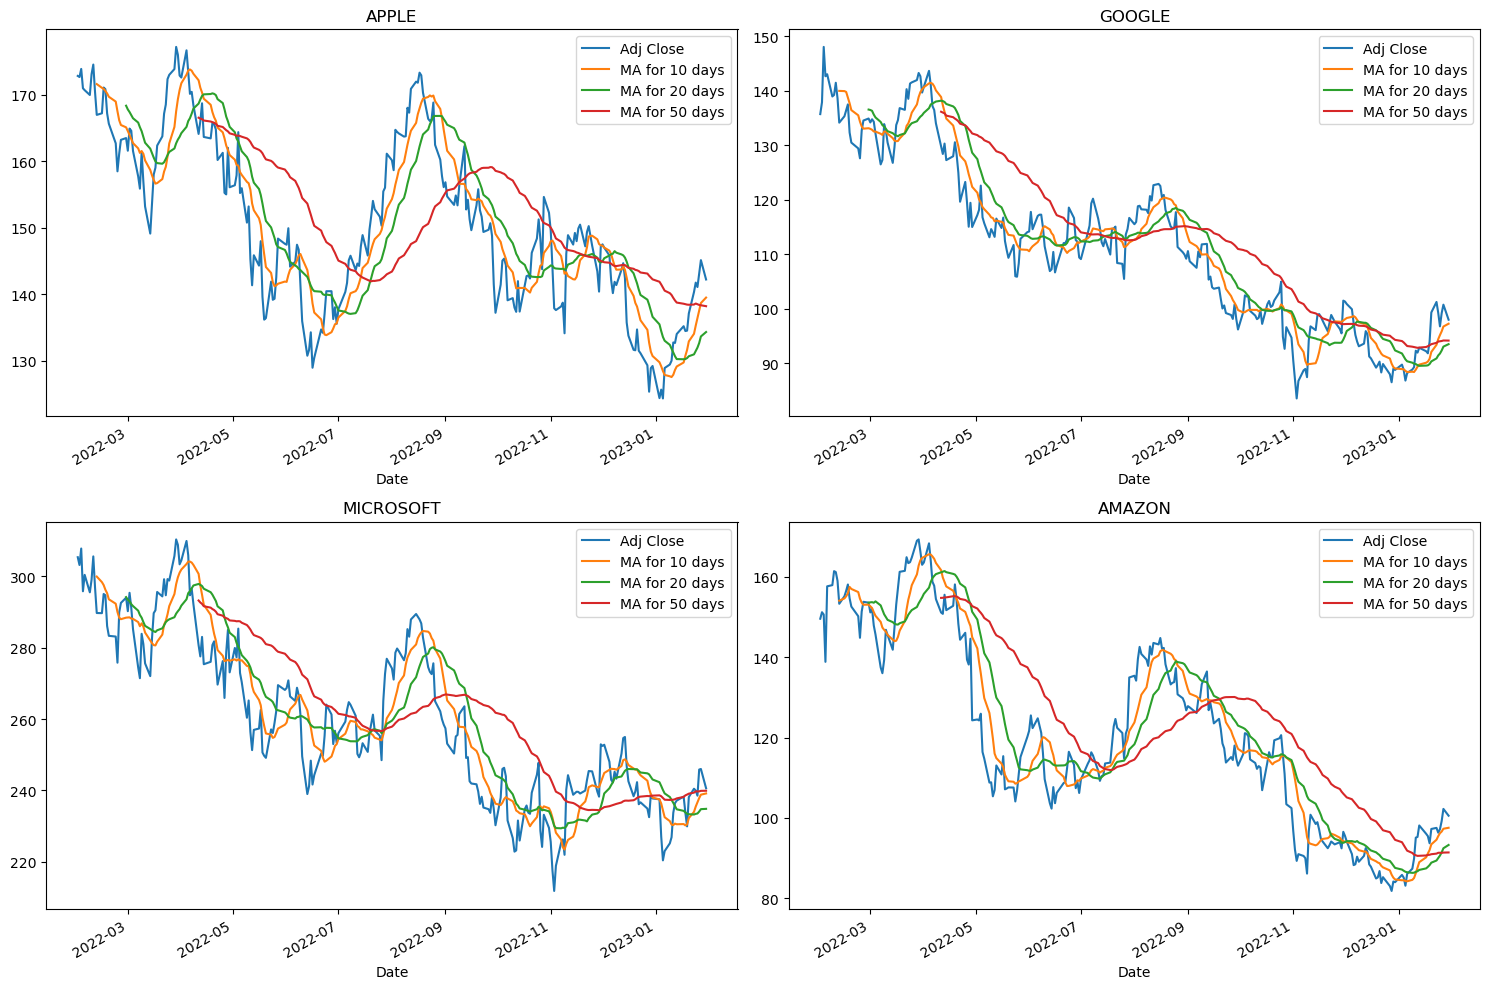

In [12]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f'MA for {ma} days'
        company[column_name] = company['Adj Close'].rolling(ma).mean()
        
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL[['Adj Close', 'MA for 10 days',
      'MA for 20 days', 'MA for 50 days']].plot(ax = axes[0,0])
axes[0,0].set_title('APPLE')

GOOG[['Adj Close', 'MA for 10 days',
      'MA for 20 days', 'MA for 50 days']].plot(ax = axes[0,1])
axes[0,1].set_title('GOOGLE')

MSFT[['Adj Close', 'MA for 10 days',
      'MA for 20 days', 'MA for 50 days']].plot(ax = axes[1,0])
axes[1,0].set_title('MICROSOFT')

AMZN[['Adj Close', 'MA for 10 days',
      'MA for 20 days', 'MA for 50 days']].plot(ax = axes[1,1])
axes[1,1].set_title('AMAZON')

fig.tight_layout()
fig.show()

We see in the graph that the best values to measure the moving average are 10 and 20 days because we still capture trends in the data without noise.

### **What was the daily return of the stock in average?**

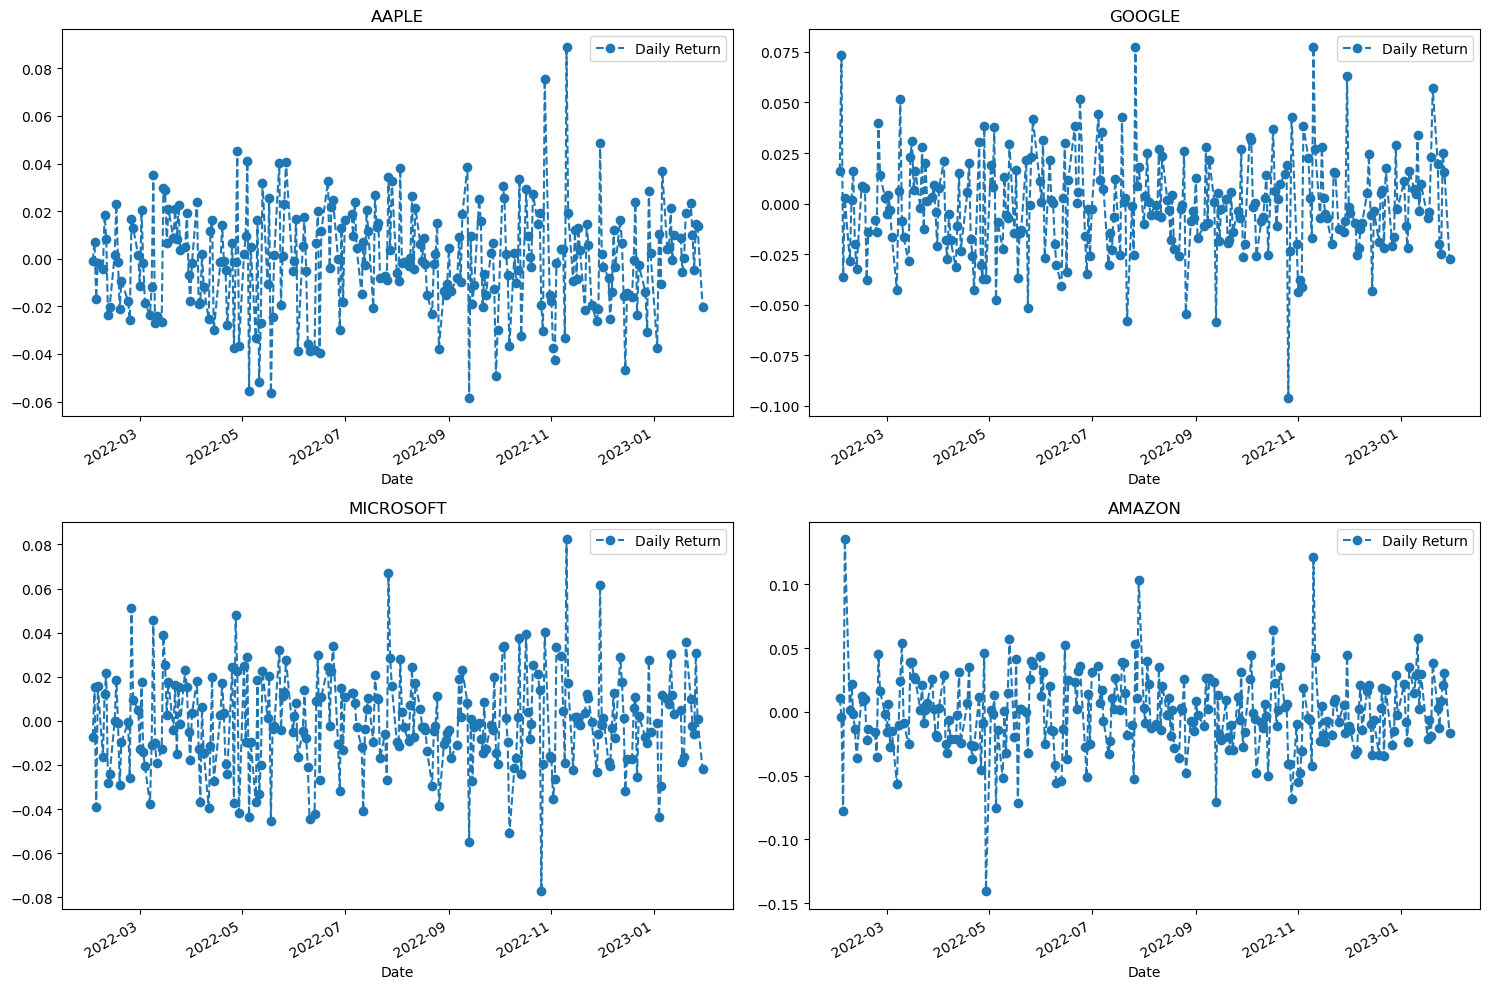

In [13]:
# we will use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()
    
# plot the daily return percentage
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL['Daily Return'].plot(ax = axes[0,0], legend = True,
                          linestyle = '--', marker = 'o')
axes[0,0].set_title('AAPLE')

GOOG['Daily Return'].plot(ax = axes[0,1], legend = True,
                          linestyle = '--', marker = 'o')
axes[0,1].set_title('GOOGLE')

MSFT['Daily Return'].plot(ax = axes[1,0], legend = True,
                          linestyle = '--', marker = 'o')
axes[1,0].set_title('MICROSOFT')

AMZN['Daily Return'].plot(ax = axes[1,1], legend = True,
                          linestyle = '--', marker = 'o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()
fig.show()

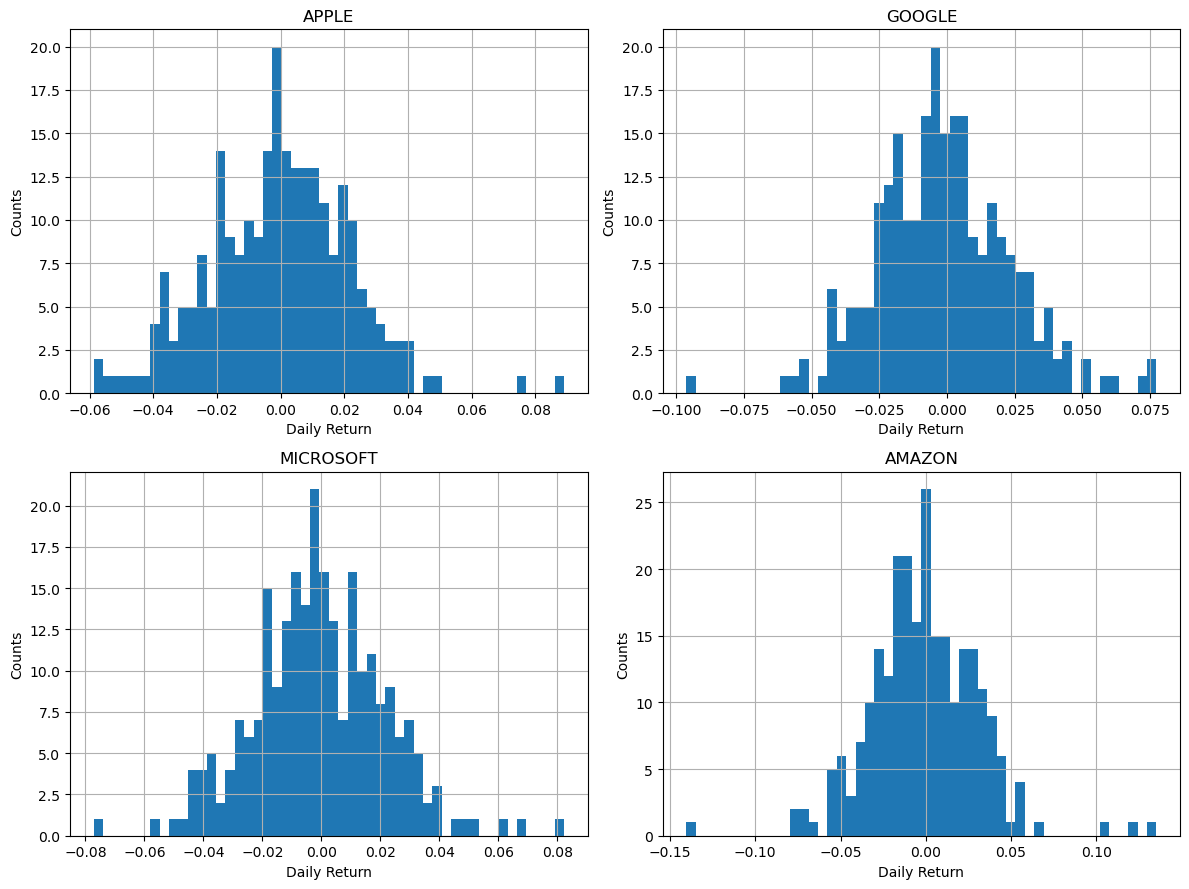

In [14]:
# histogram
plt.figure(figsize = (12, 9))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins = 50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i-1]}')
    
plt.tight_layout()
plt.show()

### **What was the correlation between different stocks closing prices?**

In [15]:
# grab all closing proces
AAPL_close = AAPL['Adj Close'].to_dict()
GOOG_close = GOOG['Adj Close'].to_dict()
MSFT_close = MSFT['Adj Close'].to_dict()
AMZN_close = AMZN['Adj Close'].to_dict()

# Convert dictionaries to DataFrames
df_AAPL = pd.DataFrame(list(AAPL_close.items()), columns=['Date', 'AAPL'])
df_GOOG = pd.DataFrame(list(GOOG_close.items()), columns=['Date', 'GOOG'])
df_MSFT = pd.DataFrame(list(MSFT_close.items()), columns=['Date', 'MSFT'])
df_AMZN = pd.DataFrame(list(AMZN_close.items()), columns=['Date', 'AMZN'])

# Merge DataFrames on the 'Date' column
closing_df = pd.merge(df_AAPL, df_GOOG, on='Date', how='outer')
closing_df = pd.merge(closing_df, df_MSFT, on='Date', how='outer')
closing_df = pd.merge(closing_df, df_AMZN, on='Date', how='outer')

# Set 'Date' column as the index
closing_df.set_index('Date', inplace=True)

# Display the merged DataFrame
closing_df.head()

,AAPL,GOOG,MSFT,AMZN
Date,,,,
2022-01-31,172.805557,135.698502,305.385284,149.573502
2022-02-01,172.637482,137.878494,303.205261,151.193497
2022-02-02,173.853577,148.036499,307.820679,150.612503
2022-02-03,170.946777,142.650497,295.830353,138.845505
2022-02-04,170.659744,143.016006,300.435974,157.639496


In [16]:
# grab all closing proces
AAPL_pct = AAPL['Adj Close'].pct_change().to_dict()
GOOG_pct = GOOG['Adj Close'].pct_change().to_dict()
MSFT_pct = MSFT['Adj Close'].pct_change().to_dict()
AMZN_pct = AMZN['Adj Close'].pct_change().to_dict()

# Convert dictionaries to DataFrames
df_AAPL = pd.DataFrame(list(AAPL_pct.items()), columns=['Date', 'AAPL'])
df_GOOG = pd.DataFrame(list(GOOG_pct.items()), columns=['Date', 'GOOG'])
df_MSFT = pd.DataFrame(list(MSFT_pct.items()), columns=['Date', 'MSFT'])
df_AMZN = pd.DataFrame(list(AMZN_pct.items()), columns=['Date', 'AMZN'])

# Merge DataFrames on the 'Date' column
tech_rets = pd.merge(df_AAPL, df_GOOG, on='Date', how='outer')
tech_rets = pd.merge(tech_rets, df_MSFT, on='Date', how='outer')
tech_rets = pd.merge(tech_rets, df_AMZN, on='Date', how='outer')

# Set 'Date' column as the index
tech_rets.set_index('Date', inplace=True)

# Display the merged DataFrame
tech_rets.head()

,AAPL,GOOG,MSFT,AMZN
Date,,,,
2022-01-31,NaN,NaN,NaN,NaN
2022-02-01,-0.000973,0.016065,-0.007139,0.010831
2022-02-02,0.007044,0.073674,0.015222,-0.003843
2022-02-03,-0.016720,-0.036383,-0.038952,-0.078128
2022-02-04,-0.001679,0.002562,0.015568,0.135359


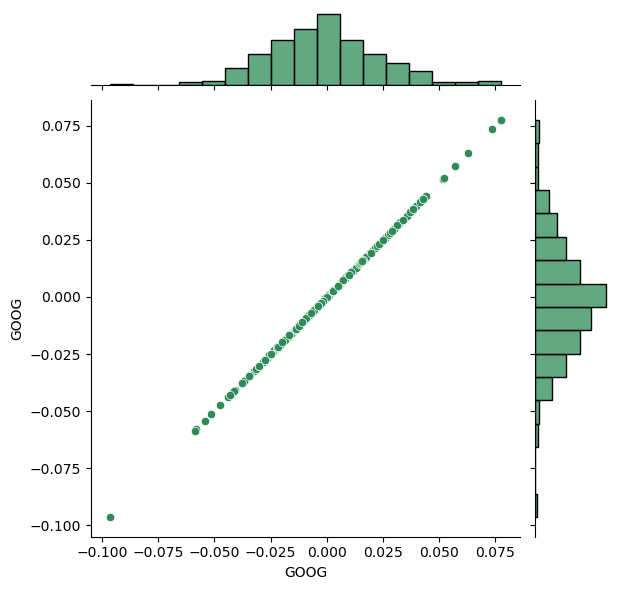

In [19]:
# compare Google to iself
sns.jointplot(x='GOOG', y='GOOG', data=tech_rets, kind='scatter',
              color='seagreen')

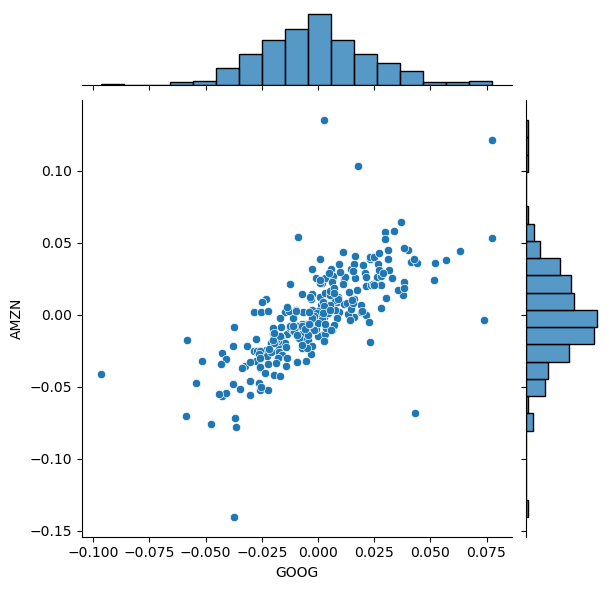

In [21]:
# compare Google to Amazon
sns.jointplot(x='GOOG', y='AMZN', data=tech_rets, kind='scatter')

We can see that if two stocks are perfectly (positively) correlated with each other, a linear relationship between its daily return values should occur.

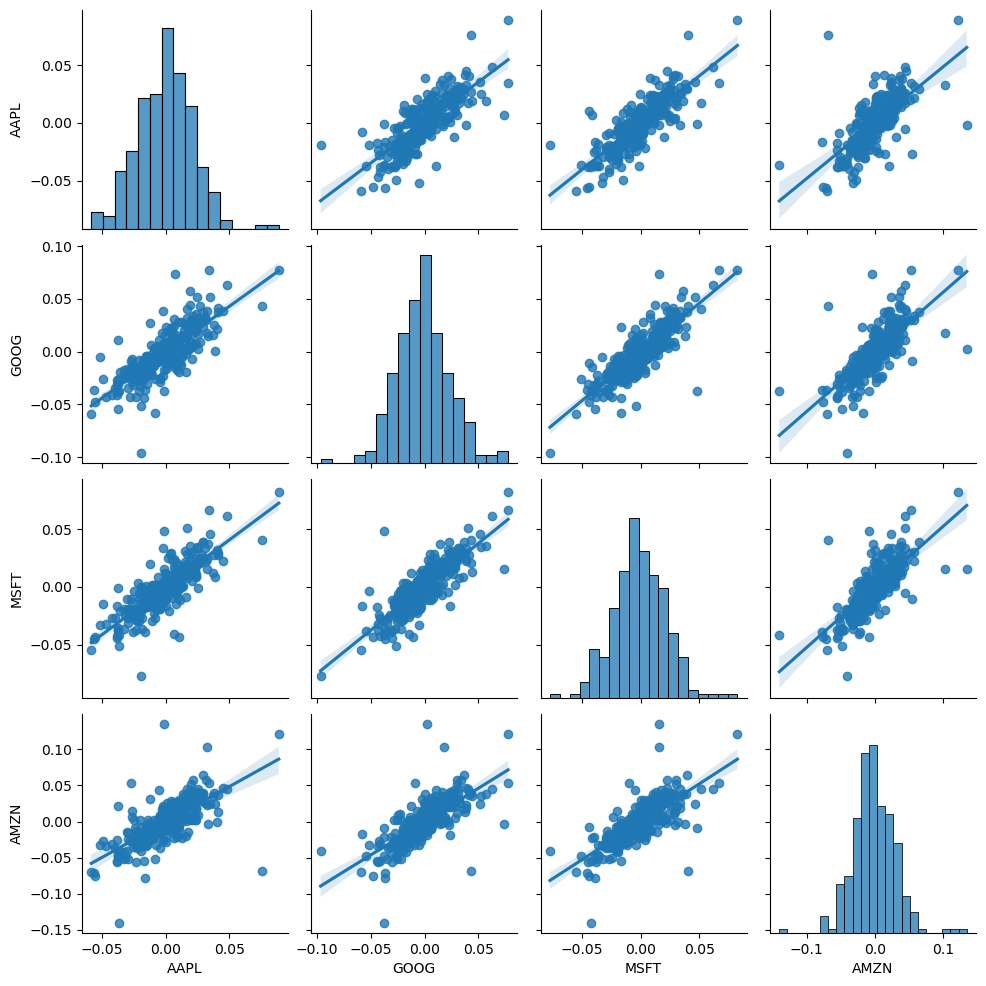

In [22]:
sns.pairplot(tech_rets, kind='reg')

A quick glance shows an interesting correlation between Google and Amazon daily returns. It might be interesting to investigate that individual comparison.

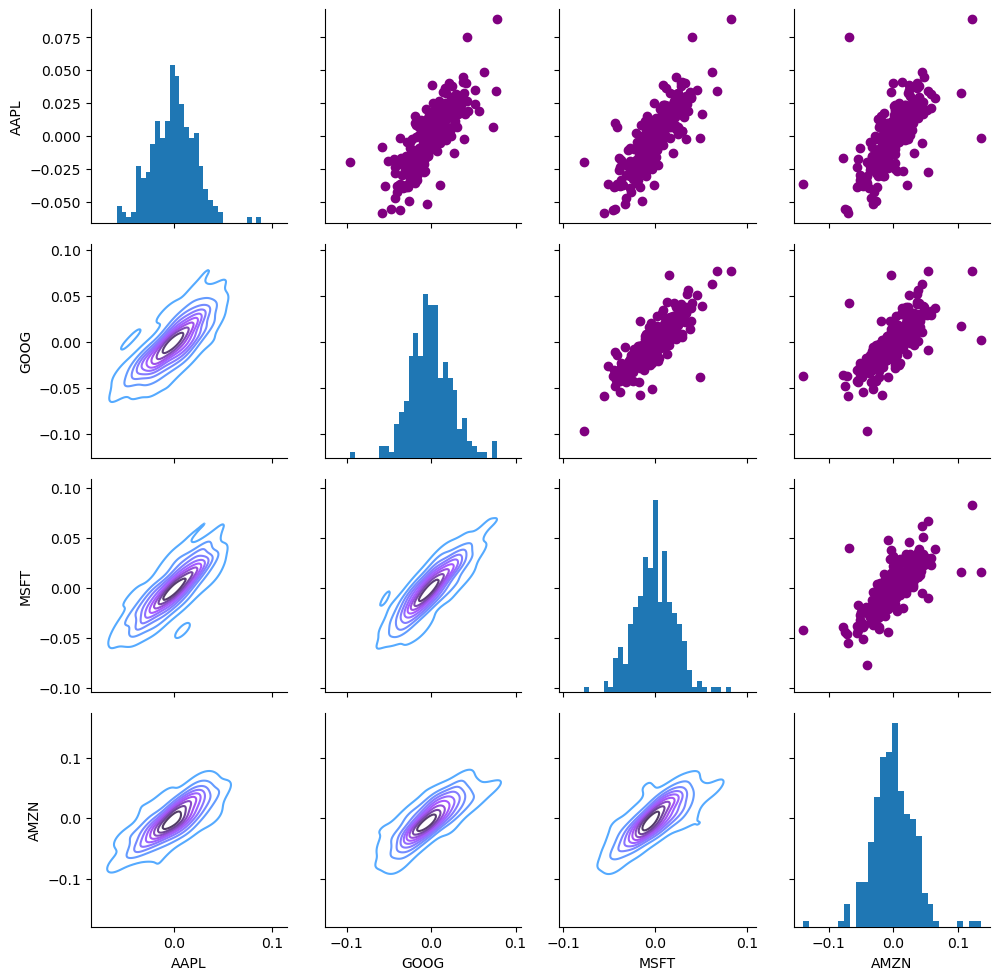

In [35]:
# percentage change of closing price

return_fig = sns.PairGrid(tech_rets.dropna())
return_fig.map_upper(plt.scatter, color='purple')
return_fig.map_lower(sns.kdeplot, cmap='cool_d')
return_fig.map_diag(plt.hist, bins=30)

plt.show()

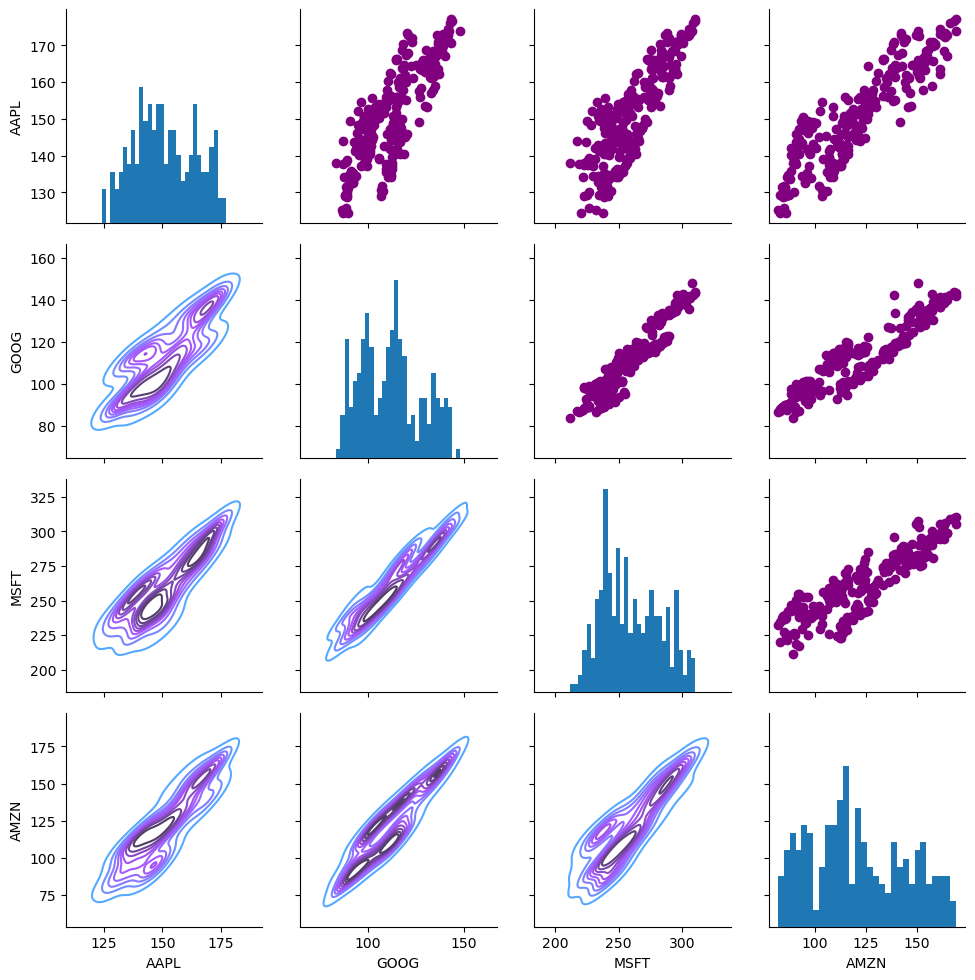

In [36]:
# closing prices

return_fig = sns.PairGrid(closing_df.dropna())
return_fig.map_upper(plt.scatter, color='purple')
return_fig.map_lower(sns.kdeplot, cmap='cool_d')
return_fig.map_diag(plt.hist, bins=30)

plt.show()

We could also do a correlation plot, to get actual numerical values for the correlation between the stocks' daily return values. By comparing the closing prices, we see an interesting relationship between Microsoft and Apple.

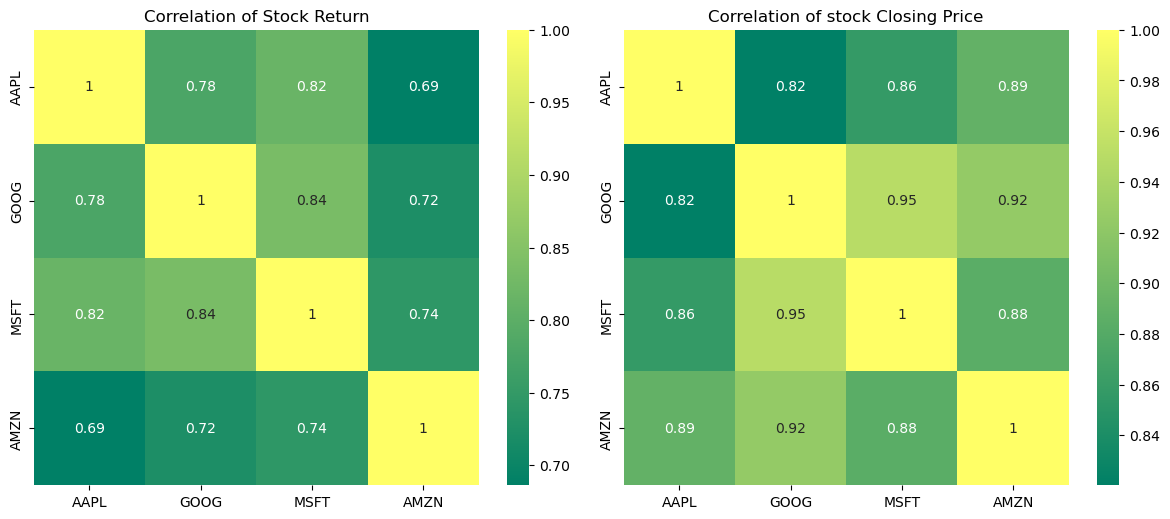

In [37]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of Stock Return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock Closing Price')

plt.tight_layout()
plt.show()

Just we suspected in our PairPlot before, we see here numerically and visually that all of the technology companies give the similar correlation of daily stock return. It's also intesting to see that all of the companies are positively correlated.

### **How much value do we put at risk by investing in a particular stock?**

There are many ways we can quantify risk, one of the most basic ways using the information we have gathered on daily percentage returns in by comparing the expected return with the standard deviation of the daily returns.

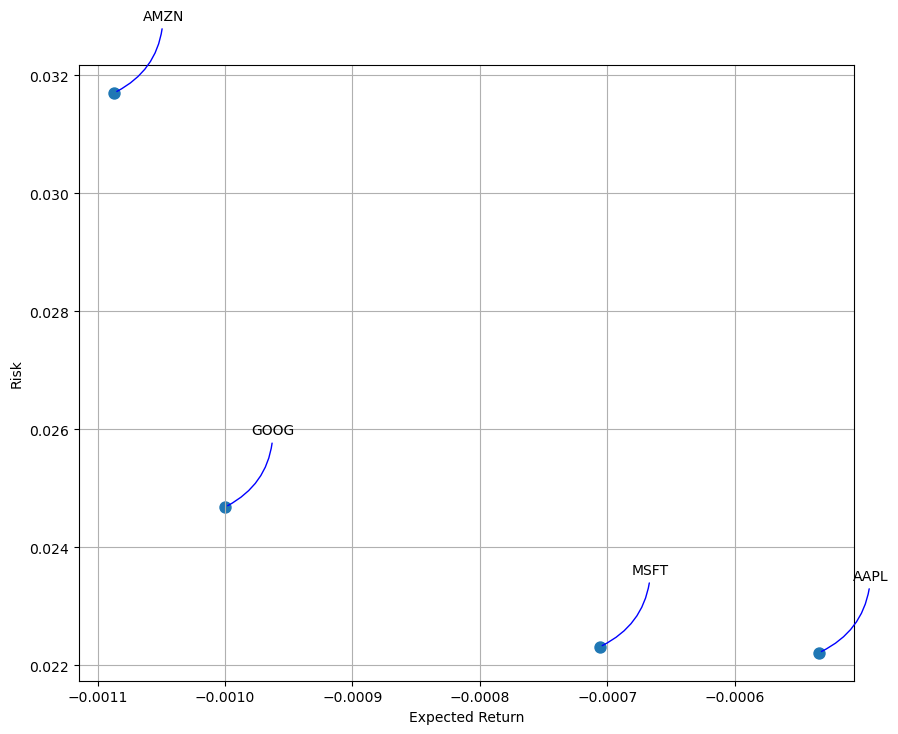

In [23]:
rets = tech_rets.dropna()
area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected Return')
plt.ylabel('Risk')
plt.grid(True)

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x,y), xytext=(50,50), textcoords='offset points',
                 ha='right', va='bottom', arrowprops=dict(arrowstyle='-', color='blue',
                                                          connectionstyle='arc3,rad=-0.3'))

    
plt.show()

## **Modelling**

### **Predicting the closing price of APPLE inc.**

In [6]:
df = yf.download('AAPL', start='2012-01-01', end=datetime.now())
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.449689,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.516600,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.655556,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.787854,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.767570,394024400
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.600006,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,193.050003,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,193.149994,48087700


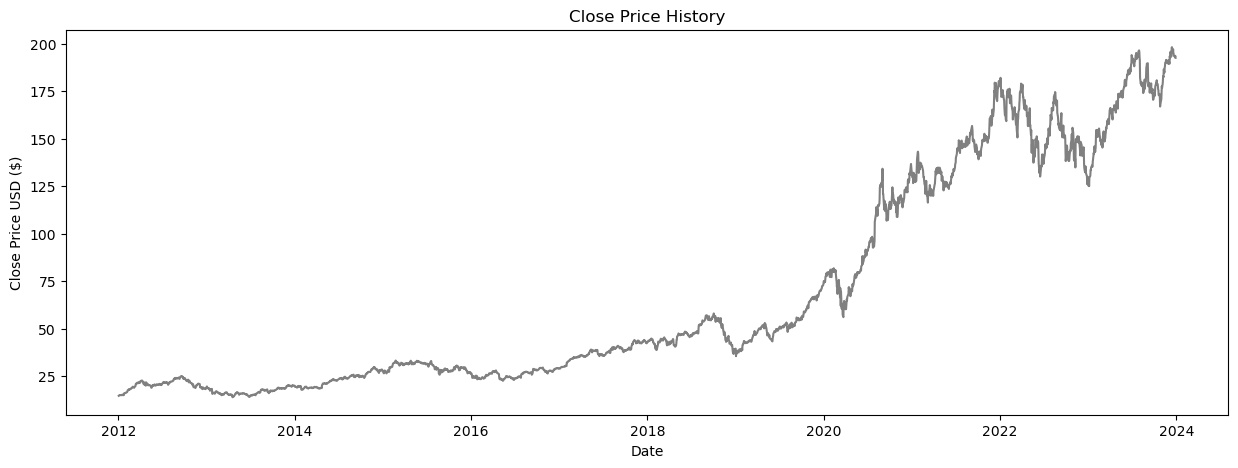

In [7]:
plt.figure(figsize = (15,5))
plt.title('Close Price History')
plt.plot(df['Close'], color = 'grey')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')

plt.show()

**Transformation to Supervised Format**

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('Var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

# scaling values
data = df.filter(['Close'])
values = data.values
scaler = MinMaxScaler(feature_range = (0,1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed

,Var1(t-1),var1(t+0)
1,0.004014,0.004443
2,0.004443,0.005333
3,0.005333,0.006180
4,0.006180,0.006051
5,0.006051,0.006343
...,...,...
3013,0.981375,0.975511
3014,0.975511,0.972524
3015,0.972524,0.973067
3016,0.973067,0.975402


**Split Values**

In [9]:
# split values
values = reframed.values
X = values[:, :-1]
y = values[:, -1]

train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 42)

# reshape in 3D [samples, timestamps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2111, 1, 1) (2111,) (906, 1, 1) (906,)


**Model Testing**

In [ ]:
# define model
def create_model(LSTM_units, dropout_rate):
    model = Sequential()
    model.add(LSTM(LSTM_units,
                   return_sequences = False,
                   input_shape = (train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    
    return model

# early stopping
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 5,
                               restore_best_weights = True)

# model testing
results = []
param_grid = {
    'LSTM_units': [128, 256, 512],
    'dropout_rate': [.1, .2],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

for LSTM_units in param_grid['LSTM_units']:
    for dropout_rate in param_grid['dropout_rate']:
        for epochs in param_grid['epochs']:
            for batch_size in param_grid['batch_size']:
                model = create_model(LSTM_units = LSTM_units, dropout_rate = dropout_rate)
                history = model.fit(train_X, train_y,
                                    epochs = epochs,
                                    batch_size = batch_size,
                                    verbose = 0,
                                    validation_data = (test_X, test_y),
                                    shuffle = False,
                                    callbacks = [early_stopping])
                mse = history.history['loss'][-1]
                score = -mse
                
                result = {
                    'MSE': mse,
                    'LSTM_units': LSTM_units,
                    'dropout_rate': dropout_rate,
                    'epochs': epochs,
                    'batch_size': batch_size
                }
                
                results.append(result)
                
results_df = pd.DataFrame(results)
print(results_df)

best_params_df = results_df.loc[results_df['MSE'].idxmin()]
print('\nBest parameters found:')
print(best_params_df)

**Fixating the Model**

Epoch 1/50
66/66 - 56s - loss: 0.0543 - val_loss: 0.0138 - 56s/epoch - 848ms/step
Epoch 2/50
66/66 - 4s - loss: 0.0027 - val_loss: 1.1747e-04 - 4s/epoch - 56ms/step
Epoch 3/50
66/66 - 4s - loss: 1.5365e-04 - val_loss: 1.1401e-04 - 4s/epoch - 54ms/step
Epoch 4/50
66/66 - 4s - loss: 1.5897e-04 - val_loss: 9.8861e-05 - 4s/epoch - 54ms/step
Epoch 5/50
66/66 - 3s - loss: 1.6352e-04 - val_loss: 1.0779e-04 - 3s/epoch - 52ms/step
Epoch 6/50
66/66 - 3s - loss: 1.5225e-04 - val_loss: 9.8379e-05 - 3s/epoch - 52ms/step
Epoch 7/50
66/66 - 3s - loss: 1.5490e-04 - val_loss: 9.5553e-05 - 3s/epoch - 53ms/step
Epoch 8/50
66/66 - 4s - loss: 1.5046e-04 - val_loss: 9.5038e-05 - 4s/epoch - 54ms/step
Epoch 9/50
66/66 - 4s - loss: 1.4888e-04 - val_loss: 9.3444e-05 - 4s/epoch - 55ms/step
Epoch 10/50
66/66 - 3s - loss: 1.4786e-04 - val_loss: 9.3226e-05 - 3s/epoch - 53ms/step
Epoch 11/50
66/66 - 3s - loss: 1.5431e-04 - val_loss: 9.2756e-05 - 3s/epoch - 53ms/step
Epoch 12/50
66/66 - 3s - loss: 1.5121e-04 - val_lo

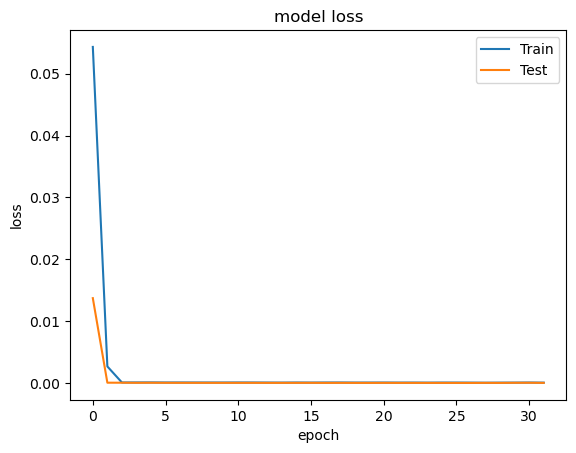

In [26]:
# model
model = Sequential()
model.add(LSTM(512, input_shape = (train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

# early stopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

# fit network
history = model.fit(train_X, train_y, epochs = 50, batch_size = 32, validation_data = (test_X, test_y),
                    verbose = 2, shuffle = False, callbacks = [early_stopping])

# summarize loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc = 'upper right')
plt.show()

In [29]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape(test_X.shape[0], 1)

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 0:]), axis = 1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 0:]), axis = 1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate regression metrics
mse = round(mean_squared_error(inv_y, inv_yhat), 2)
mae = round(mean_absolute_error(inv_y, inv_yhat), 2)
r2 = round(r2_score(inv_y, inv_yhat), 2)

# convert R-squared to a percentage
r2_percentage = r2 * 100

# print the metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2_percentage}%')

29/29 [==============================] - 20s 19ms/step
Mean Squared Error (MSE): 2.74
Mean Absolute Error (MAE): 0.94
R-squared (R2): 100.0%


**Accuration Plot**

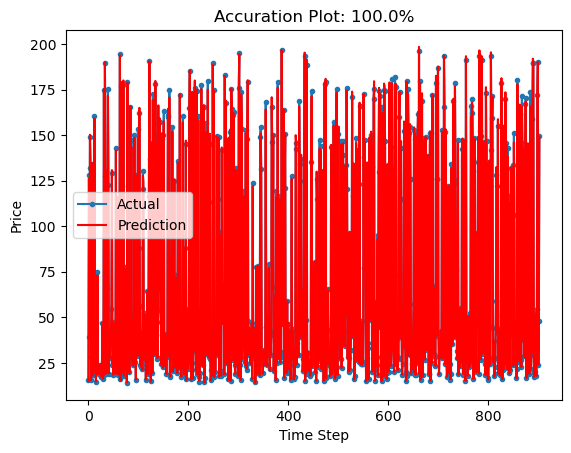

In [32]:
aa = [x for x in range(len(inv_y))]
plt.plot(aa, inv_y[:len(inv_y)], marker = '.', label = 'Actual')
plt.plot(aa, inv_yhat[:len(inv_yhat)], 'r', label = 'Prediction')
plt.title(f'Accuration Plot: {round(r2_percentage, 2)}%')
plt.ylabel('Price', size = 10)
plt.xlabel('Time Step', size = 10)
plt.legend(fontsize = 10)
plt.show()

In [39]:
# dates for predicted values
last_date = data.index[-1]
new_dates = pd.date_range(start = last_date + pd.DateOffset(days=1), periods = 7, freq = 'DS')

# extract the predicted values
predicted_values = inv_yhat[-7:]
predicted_df = pd.DataFrame({'Date': new_dates,
                             'Price': predicted_values})
predicted_df.set_index('Date')
predicted_df

ValueError: Invalid frequency: DS

In [ ]:
# create a new dataframe with only the close price column
data = df.filter(['Close'])

# convert to numpy array
dataset = data.values

# get the number of rows to train the model
training_data_len = int(np.ceil(len(dataset) * .95))
print(f'Data train length: {training_data_len}')

Data train length: 2860


In [ ]:
# scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# create data train set
train_data = scaled_data[0:int(training_data_len), :]

# split the data into X_train and y_train
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
    if i <= 61:
        print(X_train)
        print(y_train)
        print()

# convert the X_train and y_train to numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

[array([0.00401431, 0.00444289, 0.00533302, 0.00618049, 0.00605056,
       0.00634339, 0.00620958, 0.00598462, 0.00567821, 0.00662652,
       0.00748175, 0.007218  , 0.00577323, 0.00715207, 0.00579457,
       0.01088518, 0.01049151, 0.01100542, 0.01211663, 0.01278955,
       0.01273332, 0.01252582, 0.01341013, 0.01424207, 0.01518457,
       0.01670691, 0.01990478, 0.01995326, 0.02173353, 0.02306387,
       0.02077746, 0.02165789, 0.02164044, 0.02410915, 0.02375813,
       0.02440779, 0.02557523, 0.0262249 , 0.02809631, 0.02945961,
       0.02985329, 0.02999098, 0.02765997, 0.02709757, 0.02718096,
       0.02937236, 0.02998905, 0.03131358, 0.03443581, 0.03860139,
       0.0378218 , 0.03782373, 0.04083544, 0.04177794, 0.04110694,
       0.04049413, 0.03985611, 0.04197573, 0.0434302 , 0.04403914])]
[0.042534249860459186]

[array([0.00401431, 0.00444289, 0.00533302, 0.00618049, 0.00605056,
       0.00634339, 0.00620958, 0.00598462, 0.00567821, 0.00662652,
       0.00748175, 0.007218  , 0.0

In [ ]:
# built the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)




2800/2800 [==============================] - 159s 49ms/step - loss: 0.0013


In [ ]:
# create data test
test_data = scaled_data[training_data_len-60:, :]

# create X_test and y_test
X_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    
# convert to numpy array
X_test = np.array(X_test)

# reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# get the predicted values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# get the RMSE
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 4s 125ms/step


8.593132334815

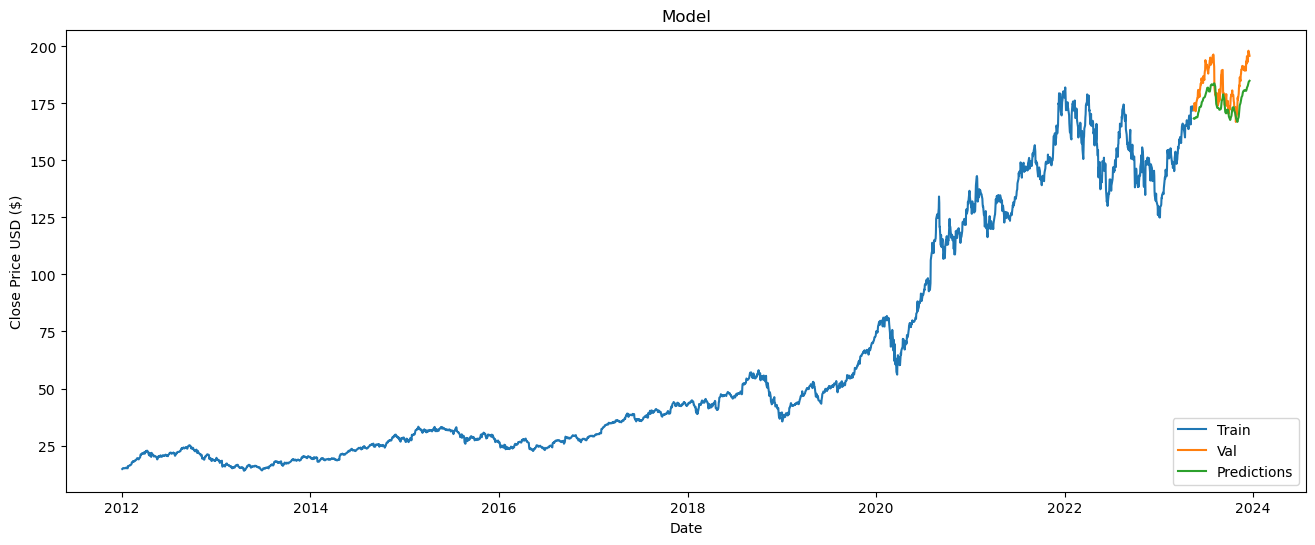

In [ ]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# visualize the data
plt.figure(figsize = (16,6))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

plt.show()

In [67]:
valid

,Close,Predictions
Date,,
2023-05-16,172.070007,168.386490
2023-05-17,172.690002,168.326599
2023-05-18,175.050003,168.216232
2023-05-19,175.160004,168.307892
2023-05-22,174.199997,168.570038
...,...,...
2023-12-12,194.710007,183.169861
2023-12-13,197.960007,183.557266
2023-12-14,198.110001,184.043396
